# Abalone dataset - linear regression

In [1]:
# Add below current directory to path
# Notebook cannot import any code without this line !!!!
import sys; sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import IntSlider, interact
from math import sqrt

from tqdm import tqdm, trange # For progress bar
%matplotlib inline
%load_ext autoreload
%autoreload 2

from src.models.CostModel import LogisticModel, RMSEModel

from src.machinery.GradientDescent import ArtemisDescent
from src.machinery.GradientUpdateMethod import ArtemisUpdate
from src.machinery.Parameters import *

from src.utils.ErrorPlotter import *
from src.utils.Constants import *
from src.utils.DataPreparation import build_data_logistic, add
from src.utils.Utilities import pickle_loader, pickle_saver
from src.utils.runner.RunnerUtilities import *
from src.utils.runner.ResultsOfSeveralDescents import ResultsOfSeveralDescents

filename = "abalone"

nb_devices_for_the_run = 10
MAX_NB_DEVICES = 10

In [2]:
import pandas as pd
data = pd.read_csv('/home/constantin/OneDrive/Documents/Etudes/Thèse/dataset/abalone/abalone.csv', sep=",", header = None)
data = data.rename(columns={ 8: "rings"})
data.head()

,0,1,2,3,4,5,6,7,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [3]:
#data = data[data.columns[range(3)]]
X_data = data.loc[:, data.columns != "rings"]
Y_data = data.loc[:, data.columns == "rings"]
dim_notebook = len(X_data.columns)
print("There is " + str(dim_notebook) + " dimensions.")
X_data.head()

There is 8 dimensions.


,0,1,2,3,4,5,6,7
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055


In [4]:
#Data normalisation
X_data[0] = X_data[0].replace(['M'], 1)
X_data[0] = X_data[0].replace(['I'], 0)
X_data[0] = X_data[0].replace(['F'], -1)
X_data.head()

/home/constantin/anaconda3/envs/artemis/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/constantin/anaconda3/envs/artemis/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/constantin/anaconda3/envs/artemis/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a co

,0,1,2,3,4,5,6,7
0,1,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150
1,1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070
2,-1,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210
3,1,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155
4,0,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055


In [5]:
print(Y_data.size)
Y_data.head()

4177


,rings
0,15
1,7
2,9
3,10
4,7


In [6]:
X_merged = torch.tensor(X_data.values, dtype=torch.float64)#.astype(dtype=np.float64)
Y_merged = torch.tensor(Y_data.values, dtype=torch.float64)
number_of_items = len(X_merged)
number_of_items_by_devices = number_of_items // nb_devices_for_the_run
print("Number of points by devices: ", number_of_items_by_devices)
X, Y = [], []

for i in range(nb_devices_for_the_run):
    X.append(X_merged[number_of_items_by_devices * i:number_of_items_by_devices * (i+1)])
    Y_temp = Y_merged[number_of_items_by_devices * i:number_of_items_by_devices * (i+1)]
    Y.append(torch.stack([y[0] for y in Y_temp]))
print("There is " + str(len(X)) + " devices.")
pickle_saver((X, Y), filename + "-data")

Number of points by devices:  417
There is 10 devices.


In [7]:
X = add_bias_term(X)
print(X[0].shape)

NameError: name 'add_bias_term' is not defined

In [130]:
%%time
obj_min_by_N = {}
for nb_devices in tqdm([10]):
    obj_min_by_N_descent = ArtemisDescent(Parameters(n_dimensions = dim_notebook, 
                                                     nb_devices=nb_devices,
                                                     nb_epoch=20000, 
                                                     quantization_param=0,
                                                     momentum = 0., 
                                                     verbose=True, 
                                                     cost_model=RMSEModel(),
                                                     stochastic=False,
                                                     bidirectional=False
                                                    ))
    obj_min_by_N_descent.set_data(X[:nb_devices],Y[:nb_devices])
    obj_min_by_N_descent.run()
    obj_min_by_N[nb_devices] = obj_min_by_N_descent.losses[-1]
pickle_saver(obj_min_by_N, filename + "-obj_min")

  0%|          | 0/1 [00:00<?, ?it/s]

   it    |   obj   
    4000 | 5.0784e+00
    8000 | 5.0584e+00
   12000 | 5.0553e+00
   16000 | 5.0547e+00


100%|██████████| 1/1 [00:34<00:00, 34.20s/it]

Gradient Descent: execution time=34.176 seconds
Final loss :  5.054510140419007

CPU times: user 2min 15s, sys: 1.16 s, total: 2min 16s
Wall time: 34.2 s


In [131]:
%%time
all_descent = {}
myX = X[:nb_devices_for_the_run]
myY = Y[:nb_devices_for_the_run]
X_number_of_bits = []
for type_params in tqdm(KIND_COMPRESSION):
    multiple_sg_descent = multiple_run_descent(type_params, myX, myY, model = RMSEModel(), 
                                               use_averaging=True, nb_epoch=100, stochastic=True)
    all_descent[type_params.name()] = multiple_sg_descent
res = ResultsOfSeveralDescents(all_descent, nb_devices_for_the_run)
pickle_saver(res, filename + "-descent")

100%|██████████| 5/5 [12:39<00:00, 151.89s/it]

CPU times: user 12min 44s, sys: 416 ms, total: 12min 44s
Wall time: 12min 39s


# With averaging

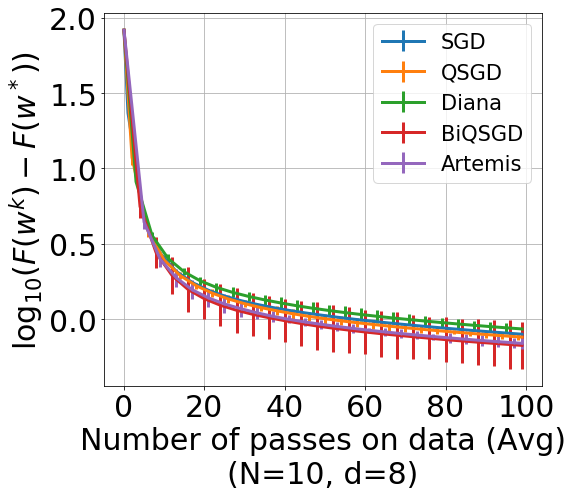

In [132]:
(X,Y) = pickle_loader(filename + "-data")
myX = X[:nb_devices_for_the_run]
myY = Y[:nb_devices_for_the_run]
obj_min_by_N = pickle_loader(filename + "-obj_min")
res = pickle_loader(filename + "-descent")
obj = obj_min_by_N[len(myX)]

plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, 
                dim_notebook, all_error=res.get_std(obj, averaged=False), x_legend="Number of passes on data (Avg)") 

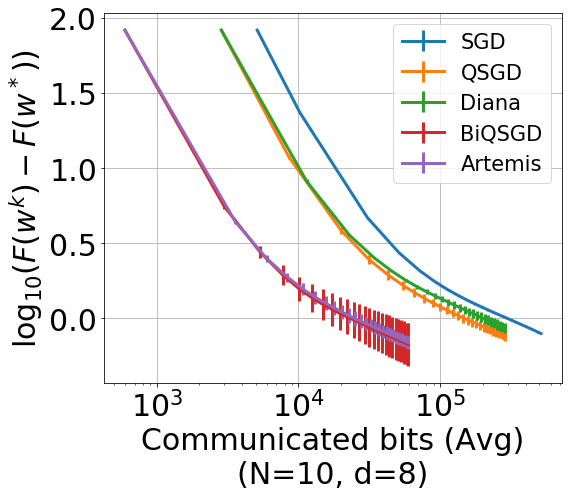

In [133]:
plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, dim_notebook, 
                x_points=res.X_number_of_bits, all_error=res.get_std(obj, averaged=True), x_legend="Communicated bits (Avg)") 


# Without averaging

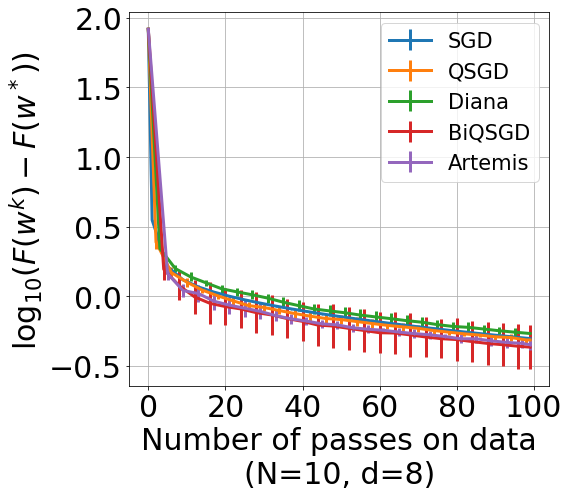

In [134]:
(X,Y) = pickle_loader(filename + "-data")
myX = X[:nb_devices_for_the_run]
myY = Y[:nb_devices_for_the_run]
obj_min_by_N = pickle_loader(filename + "-obj_min")
res = pickle_loader(filename + "-descent")
obj = obj_min_by_N[len(myX)]

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook,
               all_error=res.get_std(obj)) 

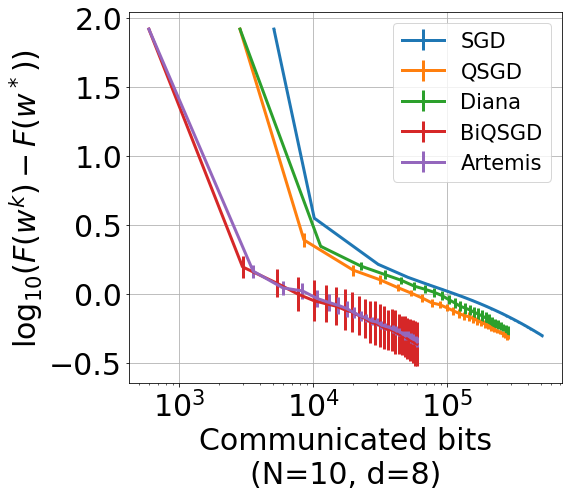

In [135]:
plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook, 
                x_points=res.X_number_of_bits, x_legend="Communicated bits", all_error=res.get_std(obj)) 